In [54]:
# https://github.com/leondgarse/keras_efficientnet_v2
%pip install -U keras-efficientnet-v2

Note: you may need to restart the kernel to use updated packages.


In [55]:
import keras_efficientnet_v2
import tensorflow as tf
from tensorflow import keras
# import tensorflow_datasets as tfds

# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
# import os
from datetime import datetime

In [56]:
# Your images folder
data_dir = (r"C:/Users/Yanki/wsp-project/AI/cat-type-data")

batch_size = 128
imgSize = 224 # regarding the target model input size

splitRate = 0.2 # split up the data for training / validation (0.2 = 80% train, 20% valid)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="training", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="validation", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

classNum = len(train_ds.class_names) # total class number
print(train_ds.class_names) # class label

Found 32033 files belonging to 94 classes.
Using 25627 files for training.
Found 32033 files belonging to 94 classes.
Using 6406 files for validation.
['Malayan cat', 'cat Abyssinian', 'cat Aegean', 'cat American Bobtail', 'cat American Curl', 'cat American Shorthair', 'cat American Wirehair', 'cat Aphrodite Giant', 'cat Arabian Mau', 'cat Asian Semi-longhair', 'cat Australian Mist', 'cat Balinese', 'cat Bambino', 'cat Bengal', 'cat Birman', 'cat Bombay', 'cat Brazilian Shorthair', 'cat British Longhair', 'cat British Shorthair', 'cat Burmese', 'cat Burmilla', 'cat California Spangled', 'cat Chantilly-Tiffany', 'cat Chartreux', 'cat Chausie', 'cat Colorpoint Shorthair', 'cat Cornish Rex', 'cat Cymric', 'cat Cyprus', 'cat Devon Rex', 'cat Donskoy', 'cat Dragon Li', 'cat Dwelf', 'cat Egyptian Mau', 'cat European Shorthair', 'cat Exotic Shorthair', 'cat Foldex', 'cat German Rex', 'cat Havana Brown', 'cat Highlander', 'cat Himalayan', 'cat Japanese Bobtail', 'cat Javanese', 'cat Kanaani', 

In [57]:
# apply data augmentation
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
  ]
)

# apply resize and rescale
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(imgSize, imgSize),
  tf.keras.layers.Rescaling(1./127.5, offset=-1)
])

In [58]:
# Expand your training dataset by expendRound numbers
expendRound = 2
temp_ds = train_ds
for i in range(expendRound):
    train_ds = train_ds.concatenate(temp_ds)

# Apply data_augmentation and resize_and_rescale for training set
train_ds = train_ds.map(lambda image,label:(data_augmentation(image),label))
train_ds = train_ds.map(lambda image,label:(resize_and_rescale(image),label))

# Apply resize_and_rescale for valid set
valid_ds = valid_ds.map(lambda image,label:(resize_and_rescale(image),label))

In [59]:
# Your base model
# SEE https://github.com/leondgarse/keras_efficientnet_v2 for more informations
baseModel = keras_efficientnet_v2.EfficientNetV1B0(pretrained="noisy_student", num_classes=classNum, drop_connect_rate=0.2)

baseModel.trainable = True
print("Layers count", len(baseModel.layers))

# Apply fine tune if needed
# fine_tune_at = int( len(baseModel.layers) * 0.2) # 20
# for layer in baseModel.layers[:fine_tune_at]:
#   layer.trainable = False
  
epochsRound = 12 # epochs round
base_learning_rate = 0.0001

# Set up a callback for saving best val_accuracy model weights
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Set up a callback for decay learning rate
def learnDecay(epoch, lr):
  if epoch < (epochsRound / 2):
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learnDecayCallback = tf.keras.callbacks.LearningRateScheduler(learnDecay)

# Set up a optimizer, loss function and metrics
baseModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Traing the model
history = baseModel.fit(train_ds, epochs=epochsRound, validation_data=valid_ds, callbacks=[model_checkpoint_callback, learnDecayCallback] )

now = datetime.now()
current_time = now.strftime("%b-%d-%Y_%H:%M:%S")

# for colab
srt = (r"C:/Users/Yanki/wsp-project/AI" + "project")

# for windows / mac
#srt = "efficientnetV1B0" + current_time + ".h5"

# import the best round weights for saving model
baseModel.load_weights(checkpoint_filepath)

test_loss, test_acc = baseModel.evaluate(valid_ds, verbose=2)
print(test_acc)

# save model
baseModel.save(srt)

>>>> Load pretrained from: C:\Users\Yanki\.keras\models/efficientnetv2\efficientnetv1-b0-noisy_student.h5
Layers count 249


c:\Users\Yanki\my-python-app\myenv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/12
603/603 [==============================] - 9647s 16s/step - loss: 3.3542 - accuracy: 0.2024 - val_loss: 2.5607 - val_accuracy: 0.3328 - lr: 1.0000e-04
Epoch 2/12
603/603 [==============================] - 16927s 28s/step - loss: 2.3922 - accuracy: 0.3683 - val_loss: 2.3325 - val_accuracy: 0.3795 - lr: 1.0000e-04
Epoch 3/12
603/603 [==============================] - 10565s 17s/step - loss: 2.0869 - accuracy: 0.4368 - val_loss: 2.2387 - val_accuracy: 0.4065 - lr: 1.0000e-04
Epoch 4/12
603/603 [==============================] - 10892s 18s/step - loss: 1.8484 - accuracy: 0.4927 - val_loss: 2.2209 - val_accuracy: 0.4149 - lr: 1.0000e-04
Epoch 5/12
603/603 [==============================] - 10882s 18s/step - loss: 1.6495 - accuracy: 0.5414 - val_loss: 2.2218 - val_accuracy: 0.4187 - lr: 1.0000e-04
Epoch 6/12
603/603 [==============================] - 10877s 18s/step - loss: 1.4732 - accuracy: 0.5840 - val_loss: 2.2639 - val_accuracy: 0.4237 - lr: 1.0000e-04
Epoch 7/12
603/603 [===

c:\Users\Yanki\my-python-app\myenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Yanki\my-python-app\myenv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


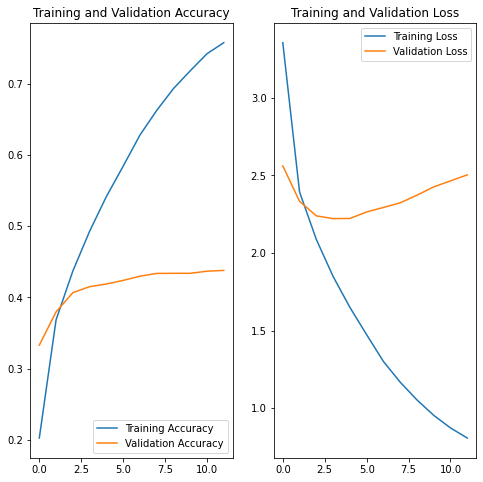

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochsRound)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
imgPath = (r"C:/Users/Yanki/Desktop/cat-type-data/cat Raas/catRaas5.jpeg")
model = tf.keras.models.load_model('project')
label = ['Malayan cat', 'cat Abyssinian', 'cat Aegean', 'cat American Bobtail', 'cat American Curl', 'cat American Shorthair', 'cat American Wirehair', 'cat Aphrodite Giant', 'cat Arabian Mau', 'cat Asian Semi-longhair', 'cat Australian Mist', 'cat Balinese', 'cat Bambino', 'cat Bengal', 'cat Birman', 'cat Bombay', 'cat Brazilian Shorthair', 'cat British Longhair', 'cat British Shorthair', 'cat Burmese', 'cat Burmilla', 'cat California Spangled', 'cat Chantilly-Tiffany', 'cat Chartreux', 'cat Chausie', 'cat Colorpoint Shorthair', 'cat Cornish Rex', 'cat Cymric', 'cat Cyprus', 'cat Devon Rex', 'cat Donskoy', 'cat Dragon Li', 'cat Dwelf', 'cat Egyptian Mau', 'cat European Shorthair', 'cat Exotic Shorthair', 'cat Foldex', 'cat German Rex', 'cat Havana Brown', 'cat Highlander', 'cat Himalayan', 'cat Japanese Bobtail', 'cat Javanese', 'cat Kanaani', 'cat Khao Manee', 'cat Kinkalow', 'cat Korat', 'cat Korean Bobtail', 'cat Kurilian Bobtail', 'cat LaPerm', 'cat Lambkin', 'cat Lykoi', 'cat Maine Coon', 'cat Manx', 'cat Mekong Bobtail', 'cat Minskin', 'cat Munchkin', 'cat Napoleon', 'cat Nebelung', 'cat Norwegian Forest Cat', 'cat Ocicat', 'cat Ojos Azules', 'cat Oriental Bicolor', 'cat Oriental Longhair', 'cat Oriental Shorthair', 'cat Persian', 'cat Peterbald', 'cat Pixie-bob', 'cat Raas', 'cat Ragamuffin', 'cat Ragdoll', 'cat Russian Blue', 'cat Sam Sawet', 'cat Savannah', 'cat Scottish Fold', 'cat Selkirk Rex', 'cat Serengeti', 'cat Serrade Petit', 'cat Siamese', 'cat Siberian', 'cat Singapura', 'cat Snowshoe', 'cat Sokoke', 'cat Somali', 'cat Sphynx', 'cat Suphalak', 'cat Thai Lilac', 'cat Tonkinese', 'cat Toyger', 'cat Turkish Angora', 'cat Turkish Van', 'cat Turkish Vankedisi', 'cat Ukrainian Levkoy', 'cat York Chocolate']

image = tf.keras.preprocessing.image.load_img(
    imgPath, color_mode="rgb", target_size=(224,224)
)
    
input_arr = ( tf.keras.preprocessing.image.img_to_array(image) / 127.5) - 1
input_arr = np.array([input_arr])

prediction = model.predict(input_arr)
print(prediction)

maxIndex = np.argmax(prediction)
print(label[maxIndex])

[[1.6767332e-06 8.3525983e-06 2.2309713e-07 8.5354994e-09 4.9309824e-11
  1.1774813e-06 2.4197536e-08 2.4312222e-08 2.1140236e-08 4.6173091e-07
  1.1976184e-06 4.7517335e-10 2.4092341e-09 1.6209607e-09 6.9334045e-11
  1.2365230e-07 3.8651706e-04 1.1607027e-08 7.7347795e-07 1.8850103e-07
  2.6139250e-07 5.0029105e-09 1.5252023e-07 2.5608568e-03 2.8654342e-06
  9.1006356e-08 6.1784938e-11 2.2400203e-08 2.9673851e-07 3.9706940e-09
  1.6188514e-08 2.0954398e-09 3.9155736e-09 4.1670809e-09 1.0748293e-07
  3.1084759e-09 8.2396161e-09 1.4448147e-09 1.6828993e-06 7.4192440e-07
  3.9673304e-10 8.7909395e-09 5.6813053e-07 2.6513144e-06 3.2810910e-08
  2.0014878e-07 1.3713777e-04 1.6192088e-07 8.5854301e-09 5.4458894e-08
  1.9413957e-08 6.2361266e-08 4.3213028e-08 2.9575025e-05 5.7893235e-10
  4.4439158e-08 3.9456292e-09 1.3177451e-07 1.7334902e-07 2.3609246e-08
  5.9352021e-09 1.2699144e-08 4.3742428e-08 2.6951230e-07 6.1772191e-08
  4.0819229e-10 3.8180548e-09 6.3517501e-07 9.9395013e-01 6.7736